In [1]:
# --- MNIST dataloader for GANs ([-1, 1] range) ---

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_mnist_dataloader(batch_size: int = 64, num_workers: int = 2, seed: int = 42):
    # Reproducibility (helps keep GAN experiments consistent)
    torch.manual_seed(seed)
    # Removed torch.cuda.manual_seed_all(seed) as it was causing CUDA errors

    # MNIST: 28x28 grayscale; map pixels from [0,1] -> [-1,1] for tanh generator output
    transform = transforms.Compose([
        transforms.ToTensor(),                  # [0,1]
        transforms.Normalize(mean=0.5, std=0.5) # -> [-1,1]
    ])

    train_set = datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform
    )

    # If you're strictly on CPU, keep workers modest (0–2). Increase if you have headroom.
    loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=False  # set True if using CUDA for the discriminator
    )
    return loader

# quick smoke test
if __name__ == "__main__":
    dl = get_mnist_dataloader(batch_size=64, num_workers=2)
    imgs, labels = next(iter(dl))
    print(imgs.shape, imgs.min().item(), imgs.max().item())  # torch.Size([64, 1, 28, 28]) ~ -1.0 to +1.0

100%|██████████| 9.91M/9.91M [00:00<00:00, 34.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 8.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.63MB/s]


torch.Size([64, 1, 28, 28]) -1.0 1.0


In [2]:
import torch
import torch.nn as nn

# -----------------------------
# Weight initialization (DCGAN-ish)
# -----------------------------
def init_weights_normal(m, std: float = 0.02):
    if isinstance(m, (nn.Linear,)):
        nn.init.normal_(m.weight, mean=0.0, std=std)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.BatchNorm1d,)):
        nn.init.normal_(m.weight, mean=1.0, std=std)
        nn.init.zeros_(m.bias)

# -----------------------------
# Generator: z(100) -> 784, tanh
# Example width: 100 -> 256 -> 512 -> 784 (you can tweak)
# -----------------------------
class Generator(nn.Module):
    def __init__(self, z_dim: int = 100, img_dim: int = 28*28, hidden_dims=(256, 512), use_bn: bool = True):
        super().__init__()
        layers = []
        prev = z_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h), nn.ReLU(inplace=True)]
            if use_bn:
                layers.insert(-1, nn.BatchNorm1d(h))  # BN before ReLU is common in DCGAN
            prev = h
        layers += [nn.Linear(prev, img_dim), nn.Tanh()]
        self.net = nn.Sequential(*layers)
        self.apply(init_weights_normal)

    def forward(self, z):
        x = self.net(z)
        return x.view(z.size(0), 1, 28, 28)  # reshape to image

# -----------------------------
# Discriminator: 784 -> 256 -> 256 -> 1, LeakyReLU, Sigmoid
# Optional Dropout for regularization (off by default)
# -----------------------------
class Discriminator(nn.Module):
    def __init__(self, img_dim: int = 28*28, hidden_dims=(256, 256), p_dropout: float = 0.0, leak: float = 0.2):
        super().__init__()
        layers = []
        prev = img_dim
        for h in hidden_dims:
            block = [nn.Linear(prev, h), nn.LeakyReLU(leak, inplace=True)]
            if p_dropout > 0:
                block.append(nn.Dropout(p_dropout))
            layers += block
            prev = h
        layers += [nn.Linear(prev, 1)] # Removed Sigmoid layer
        self.net = nn.Sequential(*layers)
        self.apply(init_weights_normal)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten 28x28 -> 784
        return self.net(x).view(x.size(0), 1) # Explicitly return shape [bsz, 1]

# -----------------------------
# Quick smoke test
# -----------------------------
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    G = Generator(z_dim=100, hidden_dims=(256, 512), use_bn=True).to(device)
    D = Discriminator(hidden_dims=(256, 256), p_dropout=0.0).to(device)

    # Parameter counts
    g_params = sum(p.numel() for p in G.parameters())
    d_params = sum(p.numel() for p in D.parameters())
    print(f"Generator params: {g_params:,}")
    print(f"Discriminator params: {d_params:,}")

    # Shapes
    z = torch.randn(16, 100, device=device)
    fake_imgs = G(z)
    preds = D(fake_imgs)
    print("Fake imgs:", fake_imgs.shape, fake_imgs.min().item(), fake_imgs.max().item())  # (16,1,28,28), ~[-1,1]
    print("D preds:", preds.shape, preds.min().item(), preds.max().item())                # (16,1), [0,1] -- now logits

    # Helper: sample a batch of images in [-1,1]
    @torch.no_grad()
    def sample_generator(generator: nn.Module, n: int = 64, z_dim: int = 100, device=device):
        z = torch.randn(n, z_dim, device=device)
        imgs = generator(z)  # [-1,1]
        return imgs

    _ = sample_generator(G, 8)

Generator params: 561,168
Discriminator params: 267,009
Fake imgs: torch.Size([16, 1, 28, 28]) -0.8178361654281616 0.8580561876296997
D preds: torch.Size([16, 1]) -0.01835235394537449 -0.0011147921904921532


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from pathlib import Path
from typing import Optional

# assumes you already defined: Generator, Discriminator, get_mnist_dataloader

class GANTrainer:
    def __init__(
        self,
        z_dim: int = 100,
        lr: float = 2e-4,
        beta1: float = 0.5,   # DCGAN trick
        beta2: float = 0.999, # DCGAN default
        label_smooth: Optional[float] = None,  # e.g., 0.9 for real labels; None to disable
        device: Optional[str] = None
    ):
        self.z_dim = z_dim
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        self.G = Generator(z_dim=z_dim, hidden_dims=(256, 512), use_bn=True).to(self.device)
        self.D = Discriminator(hidden_dims=(256, 256), p_dropout=0.0).to(self.device)

        self.criterion = nn.BCELoss()

        self.opt_G = optim.Adam(self.G.parameters(), lr=lr, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.D.parameters(), lr=lr, betas=(beta1, beta2))

        self.label_smooth = label_smooth

        # fixed noise for monitoring G's progress over time
        self.fixed_z = torch.randn(64, z_dim, device=self.device)

    def _real_labels(self, bsz: int):
        if self.label_smooth is None:
            return torch.ones(bsz, 1, device=self.device)
        # one-sided label smoothing (real labels only)
        return torch.full((bsz, 1), float(self.label_smooth), device=self.device)

    def _fake_labels(self, bsz: int):
        return torch.zeros(bsz, 1, device=self.device)

    @torch.no_grad()
    def sample_grid(self, path: str):
        self.G.eval()
        fake = self.G(self.fixed_z).cpu()                  # in [-1, 1]
        fake = (fake * 0.5) + 0.5                          # de-normalize to [0, 1]
        grid = make_grid(fake, nrow=8, padding=2)
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        save_image(grid, path)
        self.G.train()

    def train(
        self,
        dataloader,
        epochs: int = 20,
        log_interval: int = 200,
        outdir: str = "./gan_runs/mlp_mnist"
    ):
        Path(outdir).mkdir(parents=True, exist_ok=True)

        for epoch in range(1, epochs + 1):
            for i, (real_imgs, _) in enumerate(dataloader, start=1):
                bsz = real_imgs.size(0)
                real_imgs = real_imgs.to(self.device)

                # ---------------------------
                # 1) Train Discriminator
                # ---------------------------
                self.D.zero_grad(set_to_none=True)

                # Real
                real_targets = self._real_labels(bsz)                  # 1.0 or smoothed (e.g., 0.9)
                real_preds = self.D(real_imgs)                         # sigmoid outputs in [0, 1]
                d_loss_real = self.criterion(real_preds, real_targets)

                # Fake (detach so G isn't updated in this step)
                z = torch.randn(bsz, self.z_dim, device=self.device)
                fake_imgs = self.G(z).detach()
                fake_targets = self._fake_labels(bsz)                  # 0.0
                fake_preds = self.D(fake_imgs)
                d_loss_fake = self.criterion(fake_preds, fake_targets)

                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                self.opt_D.step()

                # ---------------------------
                # 2) Train Generator (non-saturating loss)
                #    maximize log(D(G(z)))  <=> minimize BCE(D(G(z)), 1)
                # ---------------------------
                self.G.zero_grad(set_to_none=True)
                z = torch.randn(bsz, self.z_dim, device=self.device)
                gen_imgs = self.G(z)
                # Use "real" labels (1) for G’s loss — the non-saturating heuristic
                g_targets = torch.ones(bsz, 1, device=self.device)
                g_preds = self.D(gen_imgs)
                g_loss = self.criterion(g_preds, g_targets)
                g_loss.backward()
                self.opt_G.step()

                if i % log_interval == 0:
                    print(
                        f"Epoch [{epoch}/{epochs}] Step [{i}/{len(dataloader)}] "
                        f"D_loss: {d_loss.item():.4f} (real {d_loss_real.item():.4f} | fake {d_loss_fake.item():.4f}) "
                        f"G_loss: {g_loss.item():.4f} "
                        f"D(x): {real_preds.mean().item():.3f} D(G(z)): {fake_preds.mean().item():.3f}/{g_preds.mean().item():.3f}"
                    )

            # save a progress grid each epoch
            self.sample_grid(f"{outdir}/samples_epoch_{epoch:03d}.png")

        # final snapshot
        torch.save(self.G.state_dict(), f"{outdir}/G_final.pt")
        torch.save(self.D.state_dict(), f"{outdir}/D_final.pt")
        self.sample_grid(f"{outdir}/samples_final.png")
        print("Training complete.")

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    dl = get_mnist_dataloader(batch_size=64, num_workers=2)
    trainer = GANTrainer(z_dim=100, lr=2e-4, beta1=0.5, beta2=0.999, label_smooth=0.9)  # set to None to disable smoothing
    trainer.train(dl, epochs=20, log_interval=200, outdir="./gan_runs/mlp_mnist")


Epoch [1/20] Step [200/938] D_loss: 1.1279 (real 0.5321 | fake 0.5958) G_loss: 0.9176 D(x): 0.621 D(G(z)): 0.448/0.402
Epoch [1/20] Step [400/938] D_loss: 1.5438 (real 0.6021 | fake 0.9417) G_loss: 1.1209 D(x): 0.573 D(G(z)): 0.608/0.328
Epoch [1/20] Step [600/938] D_loss: 1.3145 (real 0.8572 | fake 0.4573) G_loss: 0.8344 D(x): 0.426 D(G(z)): 0.366/0.435
Epoch [1/20] Step [800/938] D_loss: 1.3397 (real 0.6240 | fake 0.7157) G_loss: 1.2018 D(x): 0.565 D(G(z)): 0.508/0.302
Epoch [2/20] Step [200/938] D_loss: 1.1126 (real 0.6403 | fake 0.4723) G_loss: 1.2872 D(x): 0.557 D(G(z)): 0.371/0.283
Epoch [2/20] Step [400/938] D_loss: 1.2752 (real 1.0930 | fake 0.1822) G_loss: 1.0820 D(x): 0.358 D(G(z)): 0.166/0.350
Epoch [2/20] Step [600/938] D_loss: 1.1549 (real 0.7177 | fake 0.4372) G_loss: 1.1380 D(x): 0.518 D(G(z)): 0.348/0.328
Epoch [2/20] Step [800/938] D_loss: 1.0951 (real 0.6582 | fake 0.4368) G_loss: 1.3368 D(x): 0.561 D(G(z)): 0.351/0.269
Epoch [3/20] Step [200/938] D_loss: 1.0691 (real

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

# assumes: get_mnist_dataloader, Generator, Discriminator already defined

device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 100
epochs = 20
lr = 2e-4
betas = (0.5, 0.999)
label_smooth = 0.9  # set to None to disable one-sided smoothing on real labels

# models
G = Generator(z_dim=z_dim, hidden_dims=(256, 512), use_bn=True).to(device)
D = Discriminator(hidden_dims=(256, 256), p_dropout=0.0).to(device)

# optimizers
opt_G = optim.Adam(G.parameters(), lr=lr, betas=betas)
opt_D = optim.Adam(D.parameters(), lr=lr, betas=betas)

# loss
criterion = nn.BCELoss()

# data
loader = get_mnist_dataloader(batch_size=64, num_workers=2)

def real_labels(b):
    if label_smooth is None:
        return torch.ones(b, 1, device=device)
    return torch.full((b, 1), float(label_smooth), device=device)  # e.g., 0.9

def fake_labels(b):
    return torch.zeros(b, 1, device=device)

for epoch in range(1, epochs + 1):
    for step, (x_real, _) in enumerate(loader, start=1):
        x_real = x_real.to(device)
        bsz = x_real.size(0)

        # =======================
        # 1) Update Discriminator
        # =======================
        D.zero_grad(set_to_none=True)

        # real pass
        y_real = real_labels(bsz)
        d_real = D(x_real)                       # D(x)
        d_loss_real = criterion(d_real, y_real)

        # fake pass (detach so G isn't updated here)
        z = torch.randn(bsz, z_dim, device=device)
        with torch.no_grad():
            x_fake = G(z)
        y_fake = fake_labels(bsz)
        d_fake = D(x_fake)                       # D(G(z)) - detached
        d_loss_fake = criterion(d_fake, y_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        opt_D.step()                             # one step for D

        # ================
        # 2) Update Generator
        # ================
        G.zero_grad(set_to_none=True)

        z = torch.randn(bsz, z_dim, device=device)  # fresh noise (or reuse above; both fine)
        x_fake = G(z)
        g_pred = D(x_fake)                          # D(G(z))
        g_target = torch.ones(bsz, 1, device=device)  # non-saturating: want D to think fakes are real
        g_loss = criterion(g_pred, g_target)

        g_loss.backward()
        opt_G.step()                                 # one step for G

        if step % 200 == 0:
            print(
                f"Epoch [{epoch}/{epochs}] Step [{step}/{len(loader)}] "
                f"D_loss: {d_loss.item():.4f} (real {d_loss_real.item():.4f} | fake {d_loss_fake.item():.4f}) "
                f"G_loss: {g_loss.item():.4f} "
                f"D(x): {d_real.mean().item():.3f} D(G(z)): {d_fake.mean().item():.3f}/{g_pred.mean().item():.3f}"
            )

    # optional: save a few samples each epoch
    with torch.no_grad():
        fixed_z = torch.randn(64, z_dim, device=device)
        samples = (G(fixed_z) * 0.5) + 0.5  # de-normalize from [-1,1] -> [0,1]
        # e.g., torchvision.utils.save_image(samples, f"./gan_runs/samples_ep{epoch:03d}.png", nrow=8)


Epoch [1/20] Step [200/938] D_loss: 1.0958 (real 0.5543 | fake 0.5415) G_loss: 0.9450 D(x): 0.602 D(G(z)): 0.416/0.392
Epoch [1/20] Step [400/938] D_loss: 1.0456 (real 0.5179 | fake 0.5276) G_loss: 1.3867 D(x): 0.636 D(G(z)): 0.409/0.252
Epoch [1/20] Step [600/938] D_loss: 1.3032 (real 0.6764 | fake 0.6268) G_loss: 1.1764 D(x): 0.527 D(G(z)): 0.462/0.311
Epoch [1/20] Step [800/938] D_loss: 1.1127 (real 0.7650 | fake 0.3477) G_loss: 1.0373 D(x): 0.473 D(G(z)): 0.290/0.361
Epoch [2/20] Step [200/938] D_loss: 1.0753 (real 0.7801 | fake 0.2952) G_loss: 1.1048 D(x): 0.488 D(G(z)): 0.254/0.336
Epoch [2/20] Step [400/938] D_loss: 1.1618 (real 0.5397 | fake 0.6221) G_loss: 1.4099 D(x): 0.648 D(G(z)): 0.458/0.250
Epoch [2/20] Step [600/938] D_loss: 1.1231 (real 0.7303 | fake 0.3928) G_loss: 1.1681 D(x): 0.509 D(G(z)): 0.322/0.315
Epoch [2/20] Step [800/938] D_loss: 1.2695 (real 0.6809 | fake 0.5886) G_loss: 1.6488 D(x): 0.577 D(G(z)): 0.435/0.201
Epoch [3/20] Step [200/938] D_loss: 0.9981 (real

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# assumes: Generator, Discriminator, get_mnist_dataloader already defined

device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 100
epochs = 20
lr = 2e-4
betas = (0.5, 0.999)
label_smooth = 0.9  # set None to disable smoothing
log_interval = 200

# models
G = Generator(z_dim=z_dim, hidden_dims=(256, 512)).to(device)
D = Discriminator(hidden_dims=(256, 256)).to(device)

# optimizers
opt_G = optim.Adam(G.parameters(), lr=lr, betas=betas)
opt_D = optim.Adam(D.parameters(), lr=lr, betas=betas)

criterion = nn.BCELoss()

loader = get_mnist_dataloader(batch_size=64, num_workers=2)

def real_labels(b):
    if label_smooth is None:
        return torch.ones(b, 1, device=device)
    return torch.full((b, 1), float(label_smooth), device=device)

def fake_labels(b):
    return torch.zeros(b, 1, device=device)

for epoch in range(1, epochs + 1):
    for step, (x_real, _) in enumerate(loader, start=1):
        bsz = x_real.size(0)
        x_real = x_real.to(device)

        # -----------------
        # Train D
        # -----------------
        D.zero_grad(set_to_none=True)

        # real
        y_real = real_labels(bsz)
        d_real = D(x_real)
        d_loss_real = criterion(d_real, y_real)

        # fake
        z = torch.randn(bsz, z_dim, device=device)
        with torch.no_grad():
            x_fake = G(z)
        y_fake = fake_labels(bsz)
        d_fake = D(x_fake)
        d_loss_fake = criterion(d_fake, y_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        opt_D.step()

        # -----------------
        # Train G
        # -----------------
        G.zero_grad(set_to_none=True)

        z = torch.randn(bsz, z_dim, device=device)
        x_fake = G(z)
        g_pred = D(x_fake)
        g_targets = torch.ones(bsz, 1, device=device)  # non-saturating heuristic
        g_loss = criterion(g_pred, g_targets)
        g_loss.backward()
        opt_G.step()

        # -----------------
        # Logging
        # -----------------
        if step % log_interval == 0:
            print(
                f"Epoch [{epoch}/{epochs}] "
                f"Step [{step}/{len(loader)}] "
                f"D_loss: {d_loss.item():.4f} "
                f"(real {d_loss_real.item():.4f} | fake {d_loss_fake.item():.4f}) "
                f"G_loss: {g_loss.item():.4f} "
                f"D(x): {d_real.mean().item():.3f} "
                f"D(G(z)): {d_fake.mean().item():.3f}/{g_pred.mean().item():.3f}"
            )


Epoch [1/20] Step [200/938] D_loss: 1.0659 (real 0.5187 | fake 0.5472) G_loss: 1.1123 D(x): 0.633 D(G(z)): 0.420/0.335
Epoch [1/20] Step [400/938] D_loss: 1.1524 (real 0.5782 | fake 0.5742) G_loss: 1.1955 D(x): 0.589 D(G(z)): 0.436/0.304
Epoch [1/20] Step [600/938] D_loss: 1.2569 (real 0.6994 | fake 0.5575) G_loss: 0.9619 D(x): 0.511 D(G(z)): 0.427/0.383
Epoch [1/20] Step [800/938] D_loss: 1.0904 (real 0.5800 | fake 0.5104) G_loss: 1.6720 D(x): 0.607 D(G(z)): 0.393/0.206
Epoch [2/20] Step [200/938] D_loss: 0.9672 (real 0.5268 | fake 0.4404) G_loss: 1.6595 D(x): 0.647 D(G(z)): 0.354/0.193
Epoch [2/20] Step [400/938] D_loss: 1.2751 (real 0.4611 | fake 0.8140) G_loss: 1.8810 D(x): 0.721 D(G(z)): 0.547/0.156
Epoch [2/20] Step [600/938] D_loss: 1.3067 (real 0.3982 | fake 0.9085) G_loss: 2.3905 D(x): 0.782 D(G(z)): 0.581/0.097
Epoch [2/20] Step [800/938] D_loss: 1.0268 (real 0.6009 | fake 0.4259) G_loss: 1.4032 D(x): 0.601 D(G(z)): 0.343/0.253
Epoch [3/20] Step [200/938] D_loss: 1.2822 (real

Epoch [1/20] Step [200/938] D_loss: 1.1089 (real 0.4936 | fake 0.6153) G_loss: 1.0397 D(x): 0.654 D(G(z)): 0.459/0.360
Epoch [1/20] Step [400/938] D_loss: 1.3742 (real 0.7807 | fake 0.5935) G_loss: 0.9560 D(x): 0.461 D(G(z)): 0.446/0.387
Epoch [1/20] Step [600/938] D_loss: 1.2796 (real 0.7686 | fake 0.5109) G_loss: 1.0281 D(x): 0.479 D(G(z)): 0.397/0.364
Epoch [1/20] Step [800/938] D_loss: 0.9984 (real 0.5229 | fake 0.4754) G_loss: 1.7227 D(x): 0.646 D(G(z)): 0.373/0.185
Epoch [2/20] Step [200/938] D_loss: 1.1892 (real 0.5348 | fake 0.6544) G_loss: 1.6339 D(x): 0.646 D(G(z)): 0.473/0.204
Epoch [2/20] Step [400/938] D_loss: 1.1334 (real 0.8661 | fake 0.2673) G_loss: 0.8935 D(x): 0.432 D(G(z)): 0.233/0.416
Epoch [2/20] Step [600/938] D_loss: 1.0706 (real 0.5091 | fake 0.5616) G_loss: 1.8566 D(x): 0.683 D(G(z)): 0.415/0.164
Epoch [2/20] Step [800/938] D_loss: 1.4654 (real 0.4609 | fake 1.0045) G_loss: 1.9268 D(x): 0.716 D(G(z)): 0.620/0.152
Epoch [3/20] Step [200/938] D_loss: 1.2829 (real

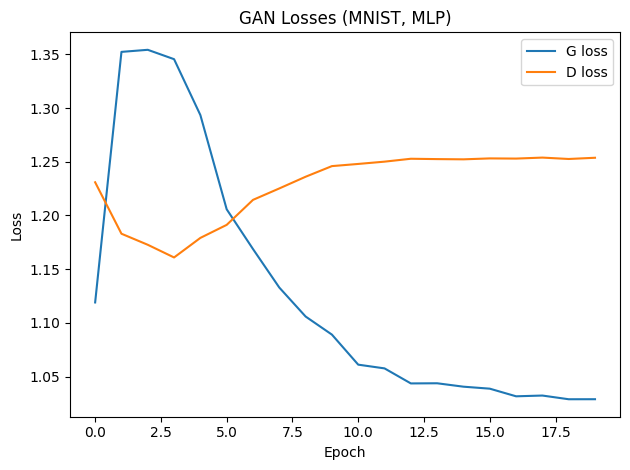

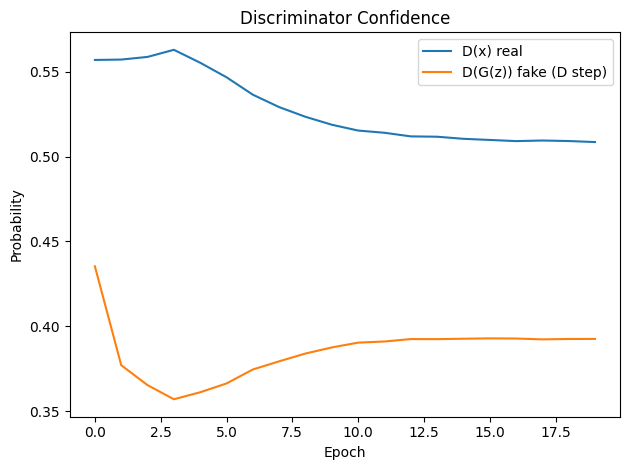

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
from pathlib import Path
import numpy as np

# assumes: Generator, Discriminator, get_mnist_dataloader already defined

device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 100
epochs = 20
lr = 2e-4
betas = (0.5, 0.999)
label_smooth = 0.9         # set to None to disable smoothing
log_interval = 200
outdir = Path("./gan_runs/mlp_mnist")
outdir.mkdir(parents=True, exist_ok=True)

# models
G = Generator(z_dim=z_dim, hidden_dims=(256, 512), use_bn=True).to(device)
D = Discriminator(hidden_dims=(256, 256), p_dropout=0.0).to(device)

# optimizers & loss
opt_G = optim.Adam(G.parameters(), lr=lr, betas=betas)
opt_D = optim.Adam(D.parameters(), lr=lr, betas=betas)
criterion = nn.BCELoss()

# data
loader = get_mnist_dataloader(batch_size=64, num_workers=2)

# fixed noise for monitoring samples (64 imgs → 8x8 grid)
torch.manual_seed(123)
fixed_z = torch.randn(64, z_dim, device=device)

def real_labels(b):
    if label_smooth is None:
        return torch.ones(b, 1, device=device)
    return torch.full((b, 1), float(label_smooth), device=device)

def fake_labels(b):
    return torch.zeros(b, 1, device=device)

# histories (per-epoch averages)
G_losses, D_losses = [], []
Dx_scores, DGz_scores = [], []   # D(x) on real; D(G(z)) on fake

for epoch in range(1, epochs + 1):
    g_loss_epoch, d_loss_epoch = [], []
    dx_epoch, dgz_epoch = [], []

    for step, (x_real, _) in enumerate(loader, start=1):
        x_real = x_real.to(device)
        bsz = x_real.size(0)

        # -----------------
        # Train D
        # -----------------
        D.zero_grad(set_to_none=True)

        # real
        y_real = real_labels(bsz)
        d_real = D(x_real)                          # D(x)
        d_loss_real = criterion(d_real, y_real)

        # fake (detach for D step)
        z = torch.randn(bsz, z_dim, device=device)
        with torch.no_grad():
            x_fake = G(z)
        y_fake = fake_labels(bsz)
        d_fake = D(x_fake)                          # D(G(z))
        d_loss_fake = criterion(d_fake, y_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        opt_D.step()

        # -----------------
        # Train G (non-saturating)
        # -----------------
        G.zero_grad(set_to_none=True)
        z = torch.randn(bsz, z_dim, device=device)
        x_fake = G(z)
        g_pred = D(x_fake)
        g_targets = torch.ones(bsz, 1, device=device)  # want D(G(z)) ~ 1
        g_loss = criterion(g_pred, g_targets)
        g_loss.backward()
        opt_G.step()

        # accumulate for per-epoch averages
        g_loss_epoch.append(g_loss.item())
        d_loss_epoch.append(d_loss.item())
        dx_epoch.append(d_real.mean().item())
        # keep both “D on fake during D step” and “D on fake during G step”; we average the former
        dgz_epoch.append(d_fake.mean().item())

        # logging
        if step % log_interval == 0:
            print(
                f"Epoch [{epoch}/{epochs}] "
                f"Step [{step}/{len(loader)}] "
                f"D_loss: {d_loss.item():.4f} (real {d_loss_real.item():.4f} | fake {d_loss_fake.item():.4f}) "
                f"G_loss: {g_loss.item():.4f} "
                f"D(x): {d_real.mean().item():.3f} "
                f"D(G(z)): {d_fake.mean().item():.3f}/{g_pred.mean().item():.3f}"
            )

    # ---------
    # end-of-epoch monitoring
    # ---------
    G_losses.append(float(np.mean(g_loss_epoch)))
    D_losses.append(float(np.mean(d_loss_epoch)))
    Dx_scores.append(float(np.mean(dx_epoch)))
    DGz_scores.append(float(np.mean(dgz_epoch)))

    # sample grid from FIXED noise to visualize progression
    G.eval()
    with torch.no_grad():
        samples = G(fixed_z)          # [-1,1]
        samples = (samples * 0.5) + 0.5
        grid = make_grid(samples, nrow=8, padding=2)
        save_image(grid, outdir / f"samples_epoch_{epoch:03d}.png")
    G.train()

# -----------------
# After training: save curves
# -----------------
plt.figure()
plt.plot(G_losses, label="G loss")
plt.plot(D_losses, label="D loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Losses (MNIST, MLP)")
plt.legend()
plt.tight_layout()
plt.savefig(outdir / "losses.png", dpi=150)

plt.figure()
plt.plot(Dx_scores, label="D(x) real")
plt.plot(DGz_scores, label="D(G(z)) fake (D step)")
plt.xlabel("Epoch")
plt.ylabel("Probability")
plt.title("Discriminator Confidence")
plt.legend()
plt.tight_layout()
plt.savefig(outdir / "discriminator_confidence.png", dpi=150)

print(f"Done. Snapshots & plots saved under: {outdir.resolve()}")


Saved: /content/gan_runs/mlp_mnist/final_grid_5x5.png
Saved: /content/gan_runs/mlp_mnist/losses_report.png


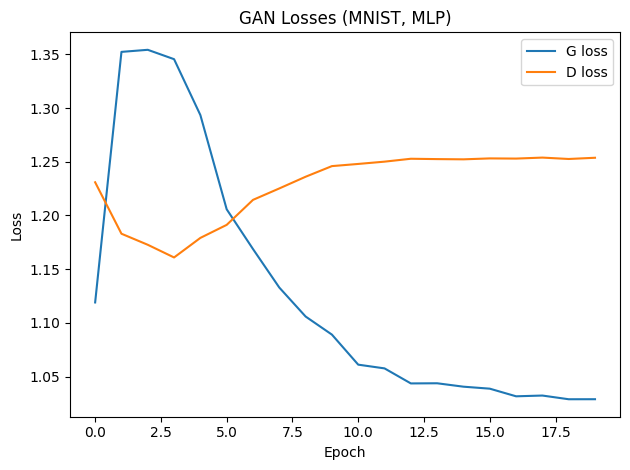

In [7]:
import torch, matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
from pathlib import Path

# --- paths
outdir = Path("./gan_runs/mlp_mnist")
outdir.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 100

# (optional) reload final generator if you trained elsewhere
# from your earlier code: Generator(...)
G = Generator(z_dim=z_dim, hidden_dims=(256,512), use_bn=True).to(device)
G.load_state_dict(torch.load(outdir / "G_final.pt", map_location=device))
G.eval()

# --- 5x5 grid from fresh noise
with torch.no_grad():
    z = torch.randn(25, z_dim, device=device)
    imgs = G(z)                         # [-1,1]
    imgs = (imgs * 0.5) + 0.5           # [0,1] for saving
    grid = make_grid(imgs, nrow=5, padding=2)
    save_image(grid, outdir / "final_grid_5x5.png")
print("Saved:", (outdir / "final_grid_5x5.png").resolve())

# --- Loss curves (if you tracked these lists during training)
# e.g., from the monitoring step: G_losses, D_losses filled per epoch
try:
    plt.figure()
    plt.plot(G_losses, label="G loss")
    plt.plot(D_losses, label="D loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("GAN Losses (MNIST, MLP)")
    plt.legend(); plt.tight_layout()
    plt.savefig(outdir / "losses_report.png", dpi=150)
    print("Saved:", (outdir / "losses_report.png").resolve())
except NameError:
    print("G_losses / D_losses not found. If you didn’t track them, rerun training with histories enabled.")


In [3]:
# --- knobs you can tweak quickly ---
FAST = {
    "z_dim": 100,
    "epochs": 15,              # shorten for demo; increase later
    "batch_size": 64,          # 32–64 CPU, 128–256 GPU if memory allows
    "g_hidden": (256, 512),    # try (128, 256) if slow
    "d_hidden": (256, 256),    # try (256, 128) if slow
    "lr": 2e-4,
    "betas": (0.5, 0.999),
    "label_smooth": 0.9,       # set to None if D underfits
    "log_interval": 300,       # reduce console spam
    "save_every_epoch": True,
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# DataLoader: tweak for throughput
loader = get_mnist_dataloader(
    batch_size=FAST["batch_size"],
    num_workers=2 if device == "cpu" else 4,  # modest workers
)


In [15]:
from torch.cuda.amp import autocast, GradScaler
import torch.nn as nn # Import nn

use_amp = (device == "cuda")
scaler_G = GradScaler(enabled=use_amp)
scaler_D = GradScaler(enabled=use_amp)

# models (re-initialize after changing Discriminator definition)
G = Generator(z_dim=FAST["z_dim"], hidden_dims=FAST["g_hidden"], use_bn=True).to(device)
D = Discriminator(hidden_dims=FAST["d_hidden"], p_dropout=0.0).to(device)

# optimizers & loss
opt_G = optim.Adam(G.parameters(), lr=FAST["lr"], betas=FAST["betas"])
opt_D = optim.Adam(D.parameters(), lr=FAST["lr"], betas=FAST["betas"])
criterion = nn.BCEWithLogitsLoss() # Changed to BCEWithLogitsLoss

# fixed noise for monitoring samples (64 imgs → 8x8 grid)
torch.manual_seed(123)
fixed_z = torch.randn(64, FAST["z_dim"], device=device)


# Note: real_labels and fake_labels now represent targets for BCEWithLogitsLoss,
# which are 1.0 for real and 0.0 for fake. Label smoothing is handled by the
# target values themselves, not the loss function.
def real_labels(bsz: int):
    if FAST["label_smooth"] is None:
        return torch.ones(bsz, 1, device=device)
    # one-sided label smoothing (real labels only)
    return torch.full((bsz, 1), float(FAST["label_smooth"]), device=device)

def fake_labels(bsz: int):
    return torch.zeros(bsz, 1, device=device)


for epoch in range(1, FAST["epochs"] + 1):
    for step, (x_real, _) in enumerate(loader, start=1):
        x_real = x_real.to(device)
        bsz = x_real.size(0)

        # -----------------
        # Train D
        # -----------------
        D.zero_grad(set_to_none=True)
        y_real = real_labels(bsz)
        y_fake = fake_labels(bsz)


        with autocast(enabled=use_amp):
            d_real = D(x_real)
            z = torch.randn(bsz, FAST["z_dim"], device=device)
            with torch.no_grad():
                x_fake = G(z)
            d_fake = D(x_fake)

        # Loss calculation outside of autocast
        d_loss_real = criterion(d_real, y_real)
        d_loss_fake = criterion(d_fake, y_fake)
        d_loss = d_loss_real + d_loss_fake

        scaler_D.scale(d_loss).backward()
        scaler_D.step(opt_D)
        scaler_D.update()

        # -----------------
        # Train G (non-saturating)
        # -----------------
        G.zero_grad(set_to_none=True)
        z = torch.randn(bsz, FAST["z_dim"], device=device)
        with autocast(enabled=use_amp):
            gen = G(z)
            g_pred = D(gen)

        # Loss calculation outside of autocast
        g_target = torch.ones(bsz, 1, device=device)  # non-saturating: want D to think fakes are real
        g_loss = criterion(g_pred, g_target)

        scaler_G.scale(g_loss).backward()
        scaler_G.step(opt_G)
        scaler_G.update()

        # logging (sparser)
        if step % FAST["log_interval"] == 0:
            # To get values in [0, 1] for logging, apply sigmoid manually
            with torch.no_grad():
                # Need to ensure d_real, d_fake, g_pred are tensors before sigmoid
                d_real_sigmoid = torch.sigmoid(d_real).mean().item()
                d_fake_sigmoid = torch.sigmoid(d_fake).mean().item()
                g_pred_sigmoid = torch.sigmoid(g_pred).mean().item()


            print(
                f"Ep[{epoch}/{FAST['epochs']}] St[{step}/{len(loader)}] "
                f"D: {d_loss.item():.4f} (r {d_loss_real.item():.4f} | f {d_loss_fake.item():.4f}) "
                f"G: {g_loss.item():.4f} D(x): {d_real_sigmoid:.3f} D(G(z)): {d_fake_sigmoid:.3f}/{g_pred_sigmoid:.3f}"
            )

    # save per-epoch grid from fixed noise (as you already implemented)
    if FAST["save_every_epoch"]:
        G.eval()
        with torch.no_grad():
            samples = G(fixed_z)    # [-1,1]
            samples = (samples * 0.5) + 0.5
            save_image(make_grid(samples, nrow=8, padding=2),
                       f"./gan_runs/mlp_mnist/samples_epoch_{epoch:03d}.png")
        G.train()

/tmp/ipython-input-2577387259.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = GradScaler(enabled=use_amp)
/tmp/ipython-input-2577387259.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = GradScaler(enabled=use_amp)
/tmp/ipython-input-2577387259.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-2577387259.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Ep[1/15] St[300/938] D: 1.3752 (r 0.5578 | f 0.8174) G: 1.0515 D(x): 0.609 D(G(z)): 0.554/0.352
Ep[1/15] St[600/938] D: 1.2079 (r 0.5502 | f 0.6576) G: 1.2929 D(x): 0.613 D(G(z)): 0.479/0.276
Ep[1/15] St[900/938] D: 1.2682 (r 0.6445 | f 0.6236) G: 1.2295 D(x): 0.561 D(G(z)): 0.462/0.298
Ep[2/15] St[300/938] D: 1.2625 (r 0.8943 | f 0.3682) G: 0.9579 D(x): 0.422 D(G(z)): 0.306/0.386
Ep[2/15] St[600/938] D: 1.1967 (r 0.4452 | f 0.7516) G: 1.7656 D(x): 0.721 D(G(z)): 0.523/0.176
Ep[2/15] St[900/938] D: 0.9851 (r 0.5737 | f 0.4115) G: 1.4635 D(x): 0.619 D(G(z)): 0.334/0.236
Ep[3/15] St[300/938] D: 1.0875 (r 0.6700 | f 0.4175) G: 1.3253 D(x): 0.566 D(G(z)): 0.333/0.275
Ep[3/15] St[600/938] D: 1.2310 (r 0.9278 | f 0.3032) G: 1.0665 D(x): 0.421 D(G(z)): 0.258/0.354
Ep[3/15] St[900/938] D: 1.1749 (r 0.8620 | f 0.3129) G: 0.9513 D(x): 0.449 D(G(z)): 0.264/0.401
Ep[4/15] St[300/938] D: 1.0401 (r 0.6644 | f 0.3756) G: 1.1028 D(x): 0.560 D(G(z)): 0.309/0.343
Ep[4/15] St[600/938] D: 1.1825 (r 0.7951

In [4]:
# --- utilities.py (you can paste into your notebook/script) ---
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Subset
from torchvision.utils import make_grid, save_image
from pathlib import Path
import numpy as np
import math

# assumes: Generator, Discriminator, get_mnist_dataloader, init_weights_normal already defined

def set_seed(seed=123):
    torch.manual_seed(seed)
    np.random.seed(seed)

def make_limited_loader(limit=None, only_class=None, batch_size=64, num_workers=2):
    """Return a DataLoader on a subset of MNIST to induce overfitting."""
    base_loader = get_mnist_dataloader(batch_size=batch_size, num_workers=num_workers)
    ds = base_loader.dataset  # torchvision.datasets.MNIST
    if limit is None and only_class is None:
        return base_loader

    idxs = np.arange(len(ds))
    if only_class is not None:
        # keep only images of a given MNIST digit (0-9)
        keep = [i for i in range(len(ds)) if int(ds[i][1]) == int(only_class)]
        idxs = np.array(keep)

    if limit is not None:
        idxs = idxs[:limit]

    subset = Subset(ds, idxs)
    from torch.utils.data import DataLoader
    return DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

def build_models(g_hidden=(256,512), d_hidden=(256,256), d_dropout=0.0, z_dim=100, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    G = Generator(z_dim=z_dim, hidden_dims=g_hidden, use_bn=True).to(device)
    D = Discriminator(hidden_dims=d_hidden, p_dropout=d_dropout).to(device)
    return G, D, device

@torch.no_grad()
def sample_grid(G, n=25, z_dim=100, device="cpu", path=None, nrow=5):
    z = torch.randn(n, z_dim, device=device)
    imgs = (G(z) * 0.5) + 0.5  # [-1,1] -> [0,1]
    grid = make_grid(imgs, nrow=nrow, padding=2)
    if path:
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        save_image(grid, path)
    return imgs, grid

def mean_pairwise_cosine(x):
    """x: tensor [N,1,28,28] in [0,1]; returns average pairwise cosine similarity (higher => more collapse)."""
    x = x.view(x.size(0), -1)
    x = x - x.mean(dim=1, keepdim=True)
    x = x / (x.norm(dim=1, keepdim=True) + 1e-8)
    sims = x @ x.t()
    n = x.size(0)
    return (sims.sum() - n) / (n*(n-1) + 1e-8)

def pixelwise_std(x):
    """x: [N,1,28,28] in [0,1]; global pixel std as a simple diversity proxy."""
    return x.std().item()


In [5]:
# --- train_experiment.py ---
import torch, torch.nn as nn, torch.optim as optim
from pathlib import Path
import numpy as np
from torchvision.utils import save_image, make_grid
# from utilities import (set_seed, build_models, sample_grid, mean_pairwise_cosine, pixelwise_std)

def run_gan_experiment(
    outdir="./gan_runs/exp",
    epochs=10,
    z_dim=100,
    batch_size=64,
    dl=None,                      # pass a DataLoader; if None, call get_mnist_dataloader() before use
    # capacity & regularization
    g_hidden=(256,512),
    d_hidden=(256,256),
    d_dropout=0.0,
    # optimization knobs
    lr_g=2e-4, lr_d=2e-4,
    betas=(0.5, 0.999),
    d_steps=1, g_steps=1,         # training ratio per batch
    label_smooth=None,            # e.g., 0.9 for real labels
    use_non_saturating=True,      # True => BCE(D(G(z)), 1); False => minimize log(1 - D(G(z)))
    seed=123,
    log_interval=200
):
    set_seed(seed)
    Path(outdir).mkdir(parents=True, exist_ok=True)
    G, D, device = build_models(g_hidden=g_hidden, d_hidden=d_hidden, d_dropout=d_dropout, z_dim=z_dim)

    opt_G = optim.Adam(G.parameters(), lr=lr_g, betas=betas)
    opt_D = optim.Adam(D.parameters(), lr=lr_d, betas=betas)
    criterion = nn.BCEWithLogitsLoss() # Changed to BCEWithLogitsLoss

    fixed_z = torch.randn(64, z_dim, device=device)

    G_losses, D_losses, Dx_hist, DGz_hist = [], [], [], []

    for ep in range(1, epochs+1):
        g_loss_acc, d_loss_acc, dx_acc, dgz_acc = [], [], [], []

        for step, (x_real, _) in enumerate(dl, start=1):
            x_real = x_real.to(device)
            bsz = x_real.size(0)

            # -------- D steps --------
            for _ in range(d_steps):
                D.zero_grad(set_to_none=True)
                # real pass
                y_real = torch.ones(bsz, 1, device=device) if label_smooth is None else torch.full((bsz,1), float(label_smooth), device=device)
                d_real = D(x_real)
                d_loss_real = criterion(d_real, y_real)

                # fake pass (detach G)
                z = torch.randn(bsz, z_dim, device=device)
                with torch.no_grad():
                    x_fake = G(z)
                y_fake = torch.zeros(bsz, 1, device=device)
                d_fake = D(x_fake)
                d_loss_fake = criterion(d_fake, y_fake)

                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                opt_D.step()

            # -------- G steps --------
            for _ in range(g_steps):
                G.zero_grad(set_to_none=True)
                z = torch.randn(bsz, z_dim, device=device)
                gen = G(z)
                d_pred = D(gen)
                if use_non_saturating:
                    # maximize log D(G(z)) == minimize BCE(D(G(z)), 1)
                    g_targets = torch.ones(bsz, 1, device=device)
                    g_loss = criterion(d_pred, g_targets)
                else:
                    # original minimax: minimize log(1 - D(G(z))) (we compute BCE to 0)
                    g_targets = torch.zeros(bsz, 1, device=device)
                    g_loss = criterion(d_pred, g_targets)
                g_loss.backward()
                opt_G.step()

            # --- logging stats (use the last D pass as proxy) ---
            g_loss_acc.append(g_loss.item())
            d_loss_acc.append(d_loss.item())
            dx_acc.append(d_real.mean().item())
            dgz_acc.append(d_fake.mean().item())

            if step % log_interval == 0:
                # Apply sigmoid manually for logging to get values in [0, 1]
                with torch.no_grad():
                    d_real_sigmoid = torch.sigmoid(d_real).mean().item()
                    d_fake_sigmoid = torch.sigmoid(d_fake).mean().item()
                    d_pred_sigmoid = torch.sigmoid(d_pred).mean().item() # Use d_pred for G step prediction

                print(f"Ep[{ep}/{epochs}] St[{step}/{len(dl)}] "
                      f"D: {d_loss.item():.4f} (r {d_loss_real.item():.4f}|f {d_loss_fake.item():.4f}) "
                      f"G: {g_loss.item():.4f} D(x): {d_real_sigmoid:.3f} D(G(z)): {d_fake_sigmoid:.3f}/{d_pred_sigmoid:.3f}")


        # epoch aggregates
        G_losses.append(float(np.mean(g_loss_acc)))
        D_losses.append(float(np.mean(d_loss_acc)))
        Dx_hist.append(float(np.mean(dx_acc)))
        DGz_hist.append(float(np.mean(dgz_acc)))

        # save epoch samples from fixed noise
        G.eval()
        with torch.no_grad():
            imgs = (G(fixed_z)*0.5)+0.5
            save_image(make_grid(imgs, nrow=8, padding=2), f"{outdir}/samples_ep{ep:03d}.png")
        G.train()

    # final artifacts + a 5x5 fresh grid
    torch.save(G.state_dict(), f"{outdir}/G_final.pt")
    torch.save(D.state_dict(), f"{outdir}/D_final.pt")
    _imgs, _ = sample_grid(G, n=25, z_dim=z_dim, device=device, path=f"{outdir}/final_grid_5x5.png", nrow=5)

    # quick diversity readout on the final fixed batch (not a full metric, but useful)
    with torch.no_grad():
        probe_imgs, _ = sample_grid(G, n=64, z_dim=z_dim, device=device, path=None, nrow=8)
        cos_sim = mean_pairwise_cosine(probe_imgs)  # higher => more collapse
        px_std = pixelwise_std(probe_imgs)          # lower => more collapse
    np.savez(f"{outdir}/history.npz",
             G_losses=G_losses, D_losses=D_losses, Dx=Dx_hist, DGz=DGz_hist,
             cos_sim=float(cos_sim), px_std=float(px_std))
    print(f"[Saved] {outdir} | cos_sim={cos_sim:.3f} (lower better) px_std={px_std:.3f} (higher better)")
    return dict(G_losses=G_losses, D_losses=D_losses, Dx=Dx_hist, DGz=DGz_hist,
                cos_sim=float(cos_sim), px_std=float(px_std))

In [6]:
# ---- induce vanishing gradients ----
# from train_experiment import run_gan_experiment
# from utilities import make_limited_loader
dl = make_limited_loader(limit=None, only_class=None, batch_size=64)  # full MNIST

# Overpower D
res_vanish = run_gan_experiment(
    outdir="./gan_runs/vanish/overpowerD",
    epochs=10, dl=dl,
    g_hidden=(256,512), d_hidden=(512,512),
    lr_g=2e-4, lr_d=1e-3,       # D learns much faster
    d_steps=5, g_steps=1,       # multiple D updates
    label_smooth=None,          # OFF (to make it worse)
    use_non_saturating=False,   # original minimax (weaker gradients) to exacerbate the issue
    seed=1
)


Ep[1/10] St[200/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[1/10] St[400/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[1/10] St[600/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[1/10] St[800/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[2/10] St[200/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[2/10] St[400/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[2/10] St[600/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[2/10] St[800/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[3/10] St[200/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[3/10] St[400/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[3/10] St[600/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000

In [7]:
# ---- mitigate vanishing gradients ----
res_vanish_fix = run_gan_experiment(
    outdir="./gan_runs/vanish/fixed",
    epochs=10, dl=dl,
    g_hidden=(256,512), d_hidden=(512,512),
    lr_g=2e-4, lr_d=2e-4,       # back to balanced
    d_steps=1, g_steps=1,
    label_smooth=0.9,           # keep D uncertain
    use_non_saturating=True,    # stronger gradients for G
    seed=1
)


Ep[1/10] St[200/938] D: 1.2878 (r 0.7029|f 0.5849) G: 1.0027 D(x): 0.506 D(G(z)): 0.442/0.368
Ep[1/10] St[400/938] D: 0.9811 (r 0.5661|f 0.4150) G: 1.2940 D(x): 0.614 D(G(z)): 0.337/0.277
Ep[1/10] St[600/938] D: 1.0535 (r 0.4096|f 0.6438) G: 2.2554 D(x): 0.773 D(G(z)): 0.467/0.107
Ep[1/10] St[800/938] D: 0.8913 (r 0.5523|f 0.3390) G: 1.7494 D(x): 0.631 D(G(z)): 0.283/0.180
Ep[2/10] St[200/938] D: 0.7948 (r 0.4571|f 0.3377) G: 2.1563 D(x): 0.723 D(G(z)): 0.281/0.121
Ep[2/10] St[400/938] D: 0.8953 (r 0.5341|f 0.3612) G: 1.7049 D(x): 0.648 D(G(z)): 0.298/0.191
Ep[2/10] St[600/938] D: 0.9733 (r 0.7172|f 0.2561) G: 1.5092 D(x): 0.535 D(G(z)): 0.219/0.234
Ep[2/10] St[800/938] D: 1.0115 (r 0.4746|f 0.5369) G: 1.9770 D(x): 0.726 D(G(z)): 0.400/0.147
Ep[3/10] St[200/938] D: 1.0754 (r 0.9547|f 0.1207) G: 1.3900 D(x): 0.418 D(G(z)): 0.112/0.267
Ep[3/10] St[400/938] D: 1.0890 (r 0.4420|f 0.6470) G: 1.8510 D(x): 0.726 D(G(z)): 0.466/0.167
Ep[3/10] St[600/938] D: 1.0801 (r 0.9193|f 0.1608) G: 0.7442

In [8]:
# ---- induce mode collapse ----
res_collapse = run_gan_experiment(
    outdir="./gan_runs/collapse/overpowerG",
    epochs=12, dl=dl,
    g_hidden=(256,512), d_hidden=(128,128),
    lr_g=1e-3, lr_d=2e-4,
    g_steps=5, d_steps=1,
    label_smooth=None,
    use_non_saturating=True,
    seed=2
)


Ep[1/12] St[200/938] D: 1.3882 (r 0.6892|f 0.6990) G: 0.6878 D(x): 0.502 D(G(z)): 0.503/0.503
Ep[1/12] St[400/938] D: 1.3909 (r 0.7033|f 0.6875) G: 0.6962 D(x): 0.495 D(G(z)): 0.497/0.498
Ep[1/12] St[600/938] D: 1.3854 (r 0.6991|f 0.6863) G: 0.6986 D(x): 0.497 D(G(z)): 0.497/0.497
Ep[1/12] St[800/938] D: 1.3868 (r 0.6970|f 0.6898) G: 0.6971 D(x): 0.498 D(G(z)): 0.498/0.498
Ep[2/12] St[200/938] D: 1.3876 (r 0.6900|f 0.6976) G: 0.6894 D(x): 0.502 D(G(z)): 0.502/0.502
Ep[2/12] St[400/938] D: 1.3874 (r 0.6937|f 0.6936) G: 0.6919 D(x): 0.500 D(G(z)): 0.500/0.501
Ep[2/12] St[600/938] D: 1.3874 (r 0.6934|f 0.6940) G: 0.6923 D(x): 0.500 D(G(z)): 0.500/0.500
Ep[2/12] St[800/938] D: 1.3864 (r 0.6917|f 0.6947) G: 0.6920 D(x): 0.501 D(G(z)): 0.501/0.501
Ep[3/12] St[200/938] D: 1.3863 (r 0.6969|f 0.6894) G: 0.6969 D(x): 0.498 D(G(z)): 0.498/0.498
Ep[3/12] St[400/938] D: 1.3856 (r 0.6890|f 0.6965) G: 0.6897 D(x): 0.502 D(G(z)): 0.502/0.502
Ep[3/12] St[600/938] D: 1.3865 (r 0.6930|f 0.6935) G: 0.6926

In [9]:
# ---- mitigate collapse ----
res_collapse_fix = run_gan_experiment(
    outdir="./gan_runs/collapse/fixed",
    epochs=12, dl=dl,
    g_hidden=(256,512), d_hidden=(256,256),
    lr_g=2e-4, lr_d=2e-4,
    g_steps=1, d_steps=2,
    label_smooth=0.9,            # optional; helps stabilize D
    use_non_saturating=True,
    seed=2
)


Ep[1/12] St[200/938] D: 0.9838 (r 0.7242|f 0.2596) G: 1.1445 D(x): 0.506 D(G(z)): 0.228/0.322
Ep[1/12] St[400/938] D: 0.9371 (r 0.7904|f 0.1467) G: 1.2898 D(x): 0.503 D(G(z)): 0.135/0.297
Ep[1/12] St[600/938] D: 0.8449 (r 0.7090|f 0.1359) G: 1.4874 D(x): 0.541 D(G(z)): 0.126/0.239
Ep[1/12] St[800/938] D: 0.7095 (r 0.5248|f 0.1846) G: 1.9857 D(x): 0.705 D(G(z)): 0.166/0.148
Ep[2/12] St[200/938] D: 0.9346 (r 0.8246|f 0.1100) G: 1.3207 D(x): 0.521 D(G(z)): 0.103/0.299
Ep[2/12] St[400/938] D: 0.9942 (r 0.8600|f 0.1343) G: 1.0473 D(x): 0.510 D(G(z)): 0.123/0.375
Ep[2/12] St[600/938] D: 0.8367 (r 0.6774|f 0.1592) G: 1.5532 D(x): 0.599 D(G(z)): 0.144/0.236
Ep[2/12] St[800/938] D: 0.8496 (r 0.6990|f 0.1506) G: 1.1367 D(x): 0.568 D(G(z)): 0.135/0.342
Ep[3/12] St[200/938] D: 0.9940 (r 0.8009|f 0.1931) G: 1.4080 D(x): 0.513 D(G(z)): 0.169/0.268
Ep[3/12] St[400/938] D: 0.9173 (r 0.6593|f 0.2580) G: 1.3275 D(x): 0.609 D(G(z)): 0.216/0.292
Ep[3/12] St[600/938] D: 0.9488 (r 0.6895|f 0.2592) G: 1.3591

In [10]:

# very small dataset (e.g., only 800 examples)
small_dl = make_limited_loader(limit=800, only_class=None, batch_size=64)

# ---- induce overfitting ----
res_overfit = run_gan_experiment(
    outdir="./gan_runs/overfit/induce",
    epochs=20, dl=small_dl,
    g_hidden=(256,512),
    d_hidden=(512,512,256),
    d_dropout=0.0,
    lr_g=2e-4, lr_d=2e-4,
    d_steps=1, g_steps=1,
    label_smooth=None,
    use_non_saturating=True,
    seed=3
)


[Saved] ./gan_runs/overfit/induce | cos_sim=0.686 (lower better) px_std=0.197 (higher better)


In [11]:
# ---- mitigate overfitting ----
res_overfit_fix = run_gan_experiment(
    outdir="./gan_runs/overfit/fixed",
    epochs=20, dl=small_dl,
    g_hidden=(256,512),
    d_hidden=(256,256),      # smaller D
    d_dropout=0.4,           # regularize
    lr_g=2e-4, lr_d=2e-4,
    d_steps=1, g_steps=1,
    label_smooth=0.9,
    use_non_saturating=True,
    seed=3
)


[Saved] ./gan_runs/overfit/fixed | cos_sim=0.838 (lower better) px_std=0.206 (higher better)


In [12]:
import numpy as np, matplotlib.pyplot as plt, os

def plot_compare(runs, labels, outpath):
    plt.figure()
    for run, label in zip(runs, labels):
        h = np.load(os.path.join(run, "history.npz"), allow_pickle=True)
        plt.plot(h["G_losses"], label=f"G {label}")
        plt.plot(h["D_losses"], label=f"D {label}", linestyle="--")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("GAN Losses")
    plt.legend(); plt.tight_layout(); plt.savefig(outpath, dpi=150); plt.close()

# examples:
plot_compare(
    ["./gan_runs/vanish/overpowerD", "./gan_runs/vanish/fixed"],
    ["vanish", "fixed"],
    "./gan_runs/vanish/compare_losses.png"
)

plot_compare(
    ["./gan_runs/collapse/overpowerG", "./gan_runs/collapse/fixed"],
    ["collapse", "fixed"],
    "./gan_runs/collapse/compare_losses.png"
)
